In [1]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, './s2spy')
from sklearn.model_selection import KFold, StratifiedKFold
import s2spy
from s2spy import RGDR
import s2spy.traintest
import utils, plotting, verification
import preprocessing as pp
path_obs_data = '~/data/volume_2/observational/'

In [2]:
target = pp.import_ds_lazy(os.path.join(path_obs_data, 'raw', 'chrips_precip_1981-2021.nc'), 
                           seldates = ('10-01', '12-31'), dailytomonths=True)
target_OND = target.groupby(target.time.dt.year).mean()

sorting longitude


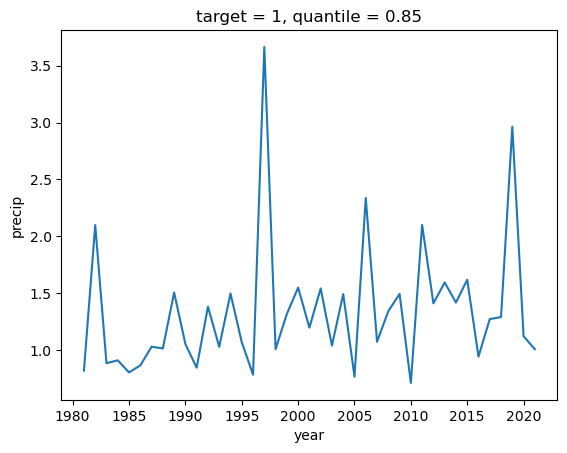

In [3]:
hoa_mask = xr.open_dataarray(os.path.join(path_obs_data, 'chirps_hoa_dry_mask_0.25deg.nc'))
target_timeseries = target_OND.where(hoa_mask).mean(dim=('latitude', 'longitude'))
target_timeseries.plot()

## Loop over different dimensionality reduction methods

In [4]:
def pipeline_dimred(X_train, y, dimred_list = [RGDR()]):
    
    if type(X_train) is not list:
        X_train = [X_train]
    assert len(X_train) == len(dimred_list), ('# of dimensionality reduction methods in dimred_list '
                                              'is unequal to the xr.DataArrays you want to reduce')
    
    for i, X_ in enumerate(X_train):
        dimred = dimred_list[i]
        if type(dimred) is type(RGDR()):
            # fit precursor field vs y for RGDR method
            dimred.fit(X_, y)
        else: # assuming EOF-like dimred from eofs package
            model = dimred(X_, dim=['anchor_year'], weights='coslat', n_modes=2)
            model.solve()
            dimred_list[i] = model # replace unitialized EOF-like class with fitted instance
            
    return dimred_list


## Develop function to merge all reduced features

In [5]:
def merge_features(X, dimred_list = [RGDR()]):
    
    if type(X) is not list:
        X = [X]
    assert len(X) == len(dimred_list), ('# of dimensionality reduction methods in dimred_list '
                                              'is unequal to the xr.DataArrays you want to reduce')
    features_list = []
    for i, X_ in enumerate(X):
        dimred = dimred_list[i]
        if type(dimred) is type(RGDR()):
            # fit precursor field vs y for RGDR method
            features = dimred.transform(X_)
            # give common dimension name to stack features
            features = features.rename({'cluster_labels':'feature'})
            # transform dimensions into shape (samples, features)
            features = features.transpose("anchor_year", "feature")            
        else: # assuming EOF-like dimred from eofs package
            features = dimred.project_onto_eofs(X_)
            features = features.rename({'mode':'feature'})

        # clear features
        empty_coords = [k for k in features.coords.keys() if k not in ['anchor_year', 'feature']]
        if len(empty_coords) != 0:
            for c in empty_coords:
                    features = features.drop(c)
        features_list.append(features)
    return xr.concat(features_list, dim='feature')

## Set up experiment:

In [6]:
from sklearn.linear_model import RidgeCV
# initialize model
regressor = RidgeCV(alphas=np.linspace(0.001, 30, 50))
# outer cross-validation

# Target is OND
y = target_timeseries.rename({'year':'anchor_year'})

# Create Advent (backwards) calendar, aligned right on anchor_date
# Resample precursor datasets to 30-day means, last date of aggregation window is 1st of september.
anchor_date = (9, 1) # anchor on first of september
cal = s2spy.time.AdventCalendar(anchor=anchor_date, freq='30d')
cal = cal.map_years(1981, 2021)

# Get and resample SST precursor field
sst = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'era5_sst_1959-2021_1_12_daily_2.0deg.nc'))
sst_resampled = s2spy.time.resample(cal, sst)
# Get and resample SM precursor field
SM = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'gleam_smsurface_1980-2021_daily_1.0deg_65S-65N.nc'))
SM_resampled = s2spy.time.resample(cal, SM)

# Select lags
lags = np.arange(0,2)
X = [sst_resampled['sst'].sel(i_interval=lags), SM_resampled['SMsurf'].sel(i_interval=lags)]
# select dimensionality reduction method per precursor dataset
dimred_list = [RGDR(), RGDR()]



./s2spy/s2spy/utils.py:69: UserWarning: The input data could not fully cover the calendar's intervals. Intervals without available data will contain NaN values.
  warnings.warn(


In [10]:
# Run experiment


# Define outer cross-validation
n_splits = 3
kfold = KFold(n_splits=n_splits)
cv = s2spy.traintest.TrainTestSplit(kfold)

test_pred = [] ; features_test_all = []
for i, (x_train, x_test, y_train, y_test) in enumerate(cv.split(*X, y=y)):

    # return fitted dimensionality reduction 
    dimred_list = pipeline_dimred(x_train, y_train, dimred_list=dimred_list)
    
    # get features
    features_train = merge_features(x_train, dimred_list = dimred_list)
    features_test = merge_features(x_test, dimred_list = dimred_list)
    # print(x_train[0].shape, x_train[1].shape)
    # print(feautures_train.shape)
    regressor.fit(features_train.values, y_train.values)
    
    y_pred_train = regressor.predict(features_train)
    y_pred = regressor.predict(features_test)

    
    features_test_all.append(features_test)
    test_pred.append(y_pred)
       
# print('Correlation coeff. {:.2f}'.format(np.corrcoef(y, np.concatenate(test_pred))[0][1]))
# plt.plot(y) ; plt.plot(np.concatenate(test_pred))

/opt/miniconda3/envs/s2spy/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: X has 20 features, but RidgeCV is expecting 31 features as input.